In [9]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt


os.chdir('//Dc1nas/projects-ab/AS/Data-OPS/Hydra Data/Intern Hydra Project 2018')

In [10]:
df = pd.read_excel('TrueCalBrazeData1.xlsx', header=0, index=0)
df_limits = pd.read_excel('TrueCalBrazeData1.xlsx', sheet_name='Spec Limits', header=0, index_col=0)

In [11]:
df = df.loc[:,[x for x in df.columns if x.count('REF') == 0 and x.count('PROFILE')==0 and x.count('Symmetry')==0]]
df_limits = df_limits.loc[[x for x in df_limits.index if x.count('REF') == 0 and x.count('PROFILE')==0 and x.count('Symmetry')==0],:]
df1 = df.iloc[:-1,3:]

nom_vals = df_limits.iloc[:,0]
tol_vals = df_limits.iloc[:,1]

#Calculating Cpk for all dimensions
df_limits['Cpl'] = [(df1.iloc[:,i].mean() - (nom_vals.iloc[i] - tol_vals.iloc[i]))/(3*df1.iloc[:,i].std()) for i in range(len(df_limits))]
df_limits['Cpu'] = [((nom_vals.iloc[i] + tol_vals.iloc[i]) - df1.iloc[:,i].mean())/(3*df1.iloc[:,i].std()) for i in range(len(df_limits))]
df_limits['Cpk'] = df_limits[['Cpl','Cpu']].min(axis=1)

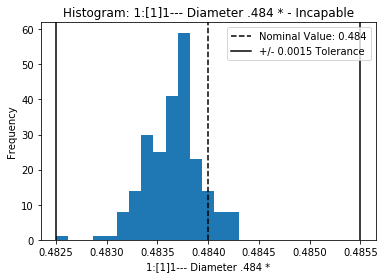

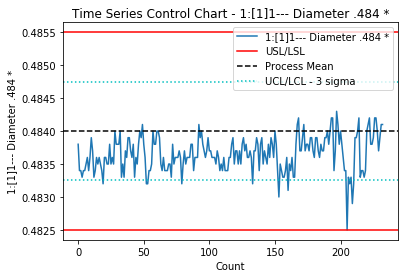

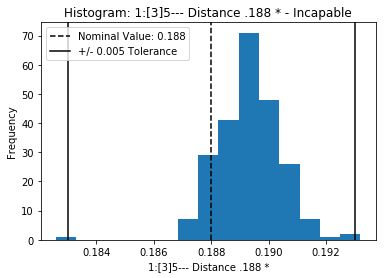

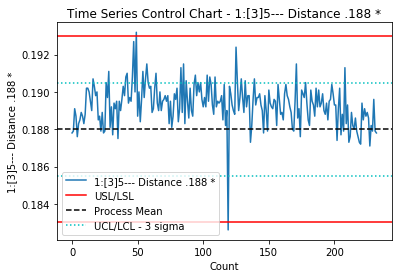

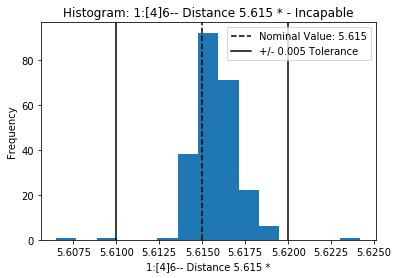

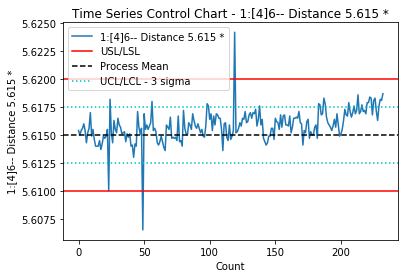

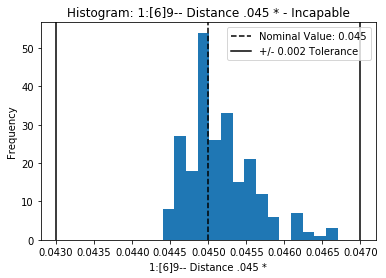

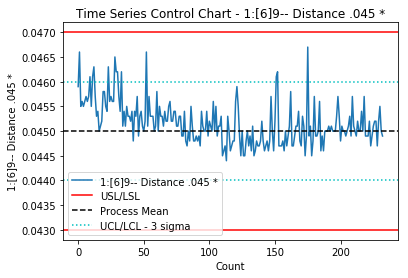

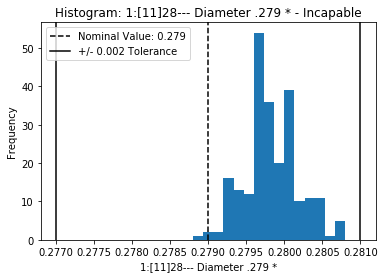

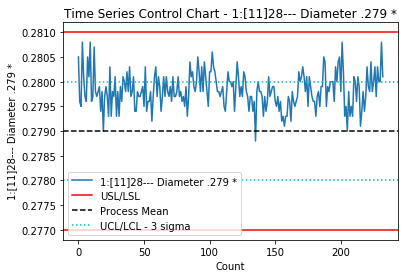

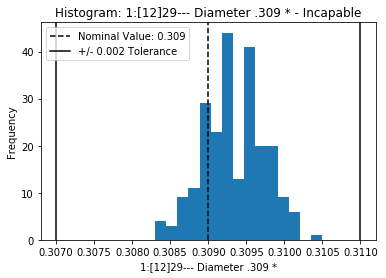

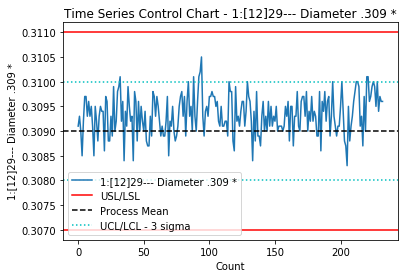

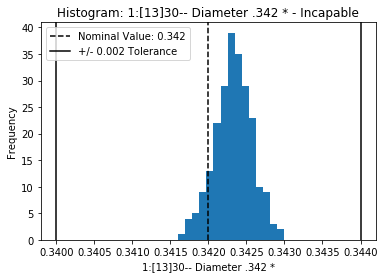

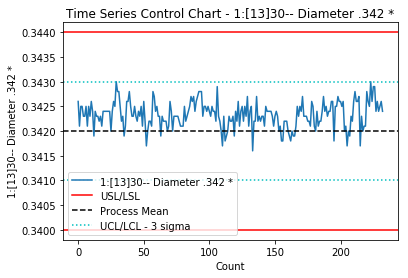

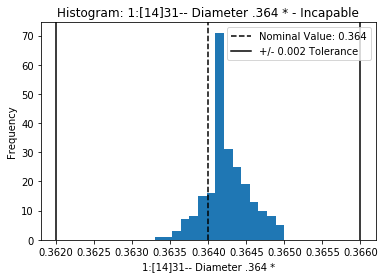

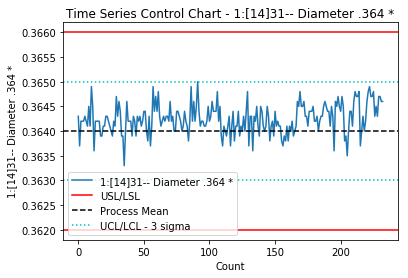

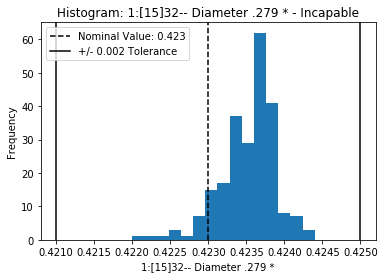

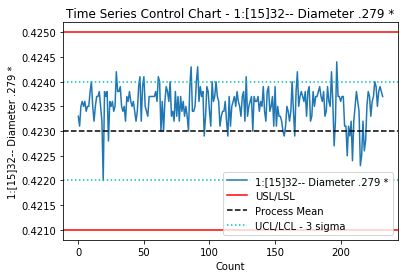

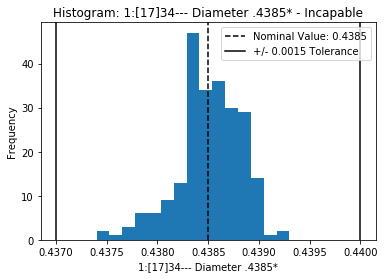

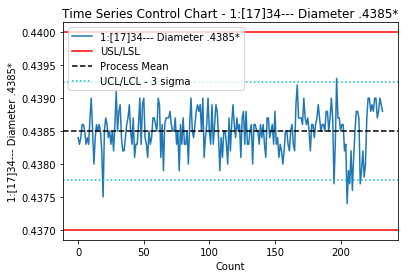

In [18]:
#Plotting histograms for dimensions that have Cpk values < 1
for i in range(len(df_limits)):
    if df_limits['Cpk'].iloc[i] < 3:
        plt.hist(df1.iloc[:,i], bins=15)
        plt.axvline(x=nom_vals.iloc[i], color='k', label='Nominal Value: {}'.format(nom_vals[i]), linestyle='--')
        plt.axvline(x=nom_vals[i]+tol_vals[i], color='k', label='+/- {} Tolerance'.format(tol_vals[i]))
        plt.axvline(x=nom_vals[i]-tol_vals[i], color='k')
        plt.title('Histogram: {} - Incapable'.format(df1.columns[i]))
        plt.ylabel('Frequency')
        plt.xlabel(df1.columns[i])
        plt.legend()
        plt.show()
        plt.plot(df1.iloc[:,i])
        plt.axhline(y=nom_vals[i]+tol_vals[i], color='r', label='USL/LSL')
        plt.axhline(y=nom_vals[i]-tol_vals[i], color='r')
        plt.axhline(y=nom_vals[i], color='k', label='Process Mean', linestyle='--')
        plt.axhline(y=nom_vals[i]+tol_vals[i]/2, color='c', label='UCL/LCL - 3 sigma', linestyle=':')
        plt.axhline(y=nom_vals[i]-tol_vals[i]/2, color='c', linestyle=':')
        plt.legend()
        plt.ylabel(df1.columns[i])
        plt.xlabel('Count')
        plt.title('Time Series Control Chart - {}'.format(df1.columns[i]))
        
        for j in range(len(df1)):
            if abs(nom_vals[i]-df1.iloc[j,i]) > nom_vals[i]+tol_vals[i]/2:
                plt.plot(j,df1.iloc[j,i], 'co')
                
            if abs(nom_vals[i]-df1.iloc[j,i]) > nom_vals[i]-tol_vals[i]/2:
                plt.plot(j,df1.iloc[j,i], 'ro')
        plt.show()

In [13]:
# Dimension Summary Information Data Frame                
# =============================================================================
dimsum_cols = ['Spec Limits', 'Process Capability', 'OOC Counts']
dimsum_index = df_limits.index
df_dimsum = pd.DataFrame(index=dimsum_index, columns=dimsum_cols)

df_dimsum['Spec Limits'] = ['{} +/- {}'.format(nom_vals[i], tol_vals[i]) for i in range(len(df_limits))]

#Proces Capability Categorization
cp_category = []
for i in df_limits['Cpk']:
    if i < 1:
        cp_category += ['Incapable']
    elif i < 2:
        cp_category += ['Capable']
    else:
        cp_category += ['Six-Sigma Capable']
df_dimsum['Process Capability'] = cp_category

#Counts at which data is out of spec
ooc_points = []
for i in range(len(df1.columns)):
    ooc_points_indv = []
    for j in enumerate(df1.iloc[:,i]):
        #If exactly on spec limit, considered out-of-control
        if abs(nom_vals[i]-df1.iloc[j[0],i]) >= tol_vals[i]:
            ooc_points_indv += [j[0]+1]
    if len(ooc_points_indv) == 0:
        ooc_points_indv += [None]
    ooc_points += [ooc_points_indv]
df_dimsum['OOC Counts'] = [", ".join(repr(x) for x in ooc_points[i]) for i in range(len(ooc_points))]

# =============================================================================
# Individual Part Summary Information Data Frame
# =============================================================================
partsum_cols = ['OOC Dimensions']
partsum_index = df['COUNT'][:-1]
df_partsum = pd.DataFrame(index=partsum_index, columns=partsum_cols)
df_partsum.index.names = ['Part Count #']

#Dimensions out of spec for each part                          
ooc_dims = []
for i in range(len(df1)):
    ooc_dims_indv = []
    for j in range(len(df1.columns)):
        if abs(nom_vals[j]-df1.iloc[i,j]) >= tol_vals[j]:
            ooc_dims_indv += [df1.columns[j]]
    if len(ooc_dims_indv) == 0:
        ooc_dims_indv += [None]
    ooc_dims += [ooc_dims_indv]
df_partsum['OOC Dimensions'] = [', '.join(repr(x) for x in ooc_dims[i]) for i in range(len(ooc_dims))]
#Filtering out parts not out-of-control
df_partsum = df_partsum[df_partsum['OOC Dimensions'] != 'None']


In [16]:
df_dimsum

,Spec Limits,Process Capability,OOC Counts
Dimension Name,,,
1:[1]1--- Diameter .484 *,0.484 +/- 0.0015,Capable,206
1:[2]2--- Diameter .430 *,0.43 +/- 0.005,Six-Sigma Capable,None
1:[3]5--- Distance .188 *,0.188 +/- 0.005,Capable,"50, 120"
1:[4]6-- Distance 5.615 *,5.615 +/- 0.005,Incapable,"50, 120"
1:[6]9-- Distance .045 *,0.045 +/- 0.002,Capable,None
1:[11]28--- Diameter .279 *,0.279 +/- 0.002,Capable,None
1:[12]29--- Diameter .309 *,0.309 +/- 0.002,Capable,None
1:[13]30-- Diameter .342 *,0.342 +/- 0.002,Six-Sigma Capable,None
1:[14]31-- Diameter .364 *,0.364 +/- 0.002,Capable,None


In [17]:
df_partsum

,OOC Dimensions
Part Count #,
50,"'1:[3]5--- Distance .188 *', '1:[4]6-- Distanc..."
120,"'1:[3]5--- Distance .188 *', '1:[4]6-- Distanc..."
206,'1:[1]1--- Diameter .484 *'
